## Wikimedia Data Analysis Task

In [1]:
%matplotlib inline
%cd documents\github\Discovery-Hiring-Analyst-2016

C:\Users\jose\documents\github\Discovery-Hiring-Analyst-2016


First we import the relevant libraries, then read the data into a DataFrame.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
raw_data = pd.read_csv("events_log.csv.gz", compression = "infer")

In [4]:
raw_data.head()

uuid     timestamp        session_id group  \
0  00000736167c507e8ec225bd9e71f9e5  2.016030e+13  78245c2c3fba013a     b   
1  00000c69fe345268935463abbfa5d5b3  2.016031e+13  c559c3be98dca8a4     a   
2  00003bfdab715ee59077a3670331b787  2.016030e+13  760bf89817ce4b08     a   
3  0000465cd7c35ad2bdeafec953e08c1a  2.016030e+13  fb905603d31b2071     a   
4  000050cbb4ef5b42b16c4d2cf69e6358  2.016030e+13  c2bf5e5172a892dc     a   

             action  checkin           page_id  n_results  result_position  
0  searchResultPage      NaN  cbeb66d1bc1f1bc2        5.0              NaN  
1  searchResultPage      NaN  eb658e8722aad674       10.0              NaN  
2           checkin     30.0  f99a9fc1f7fdd21e        NaN              NaN  
3           checkin     60.0  e5626962a6939a75        NaN             10.0  
4           checkin     30.0  787dd6a4c371cbf9        NaN              NaN

Next we get some basic information about the data and start checking for missing values and other pathologies.

In [5]:
raw_data.shape

(400165, 9)

In [6]:
raw_data.count()

uuid               400165
timestamp          400165
session_id         400165
group              400165
action             400165
checkin            223824
page_id            400165
n_results          136234
result_position    230482
dtype: int64

Based on the column definitions, these counts don't suggest anything out of the ordinary - not every event will trigger a checkin, not every search will return results, and not every session will involve selecting a result. We can conclude that there is no blatantly missing data.

Our next step will be to convert the elements of the timestamp column from strings to Datetime objects, which will make them easier to work with. Since we're actually changing the DataFrame at this point, we'll create a copy of the original data first and make changes to the copy.

In [7]:
data = raw_data.copy(deep = True)

In [8]:
data['timestamp'] = data['timestamp'].apply(int)
data['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y%m%d%H%M%S')

In [9]:
data['timestamp'].head()

0   2016-03-01 10:38:42
1   2016-03-07 00:52:26
2   2016-03-02 14:53:05
3   2016-03-02 22:27:01
4   2016-03-02 09:50:23
Name: timestamp, dtype: datetime64[ns]

Next we verify that the elements in the categorical columns correspond to the ones given in the column definitions.

In [10]:
data['group'].unique()

array(['b', 'a'], dtype=object)

In [11]:
data['action'].unique()

array(['searchResultPage', 'checkin', 'visitPage'], dtype=object)

Next, we check that every event either has a checkin time, or isn't a checkin event. We do this by adding the number of non-checkin events and the number of non-null entries in the checkin column and checking whether it's equal to the total number of rows in the DataFrame.

In [12]:
data.loc[data['action'] != 'checkin', :].shape[0] + data.loc[pd.notnull(data['checkin'])].shape[0] == data.shape[0]

True

Next, we check that every searchResultPage event has a non-null value for n_results.

In [13]:
data.loc[data['action'] == 'searchResultPage'].shape[0] == data.loc[pd.notnull(data['n_results'])].shape[0]

True

Next, we check that every non-searchResultPage event has a result position. Equivalently, we are checking that every non-search event is coming from a search event.

In [14]:
data.loc[data['action'] != 'searchResultPage'].shape[0] == data.loc[pd.notnull(data['result_position'])].shape[0]

False

It turns out that this isn't the case. We can get a look at what's happening by examining a session with a non-search event that has no result position:

In [15]:
data.loc[(data['action'] != 'searchResultPage') & ~pd.notnull(data['result_position']), :].head()

uuid           timestamp        session_id  \
2   00003bfdab715ee59077a3670331b787 2016-03-02 14:53:05  760bf89817ce4b08   
4   000050cbb4ef5b42b16c4d2cf69e6358 2016-03-02 09:50:23  c2bf5e5172a892dc   
5   0000a6af2baa5af1be2431e84cb01da1 2016-03-02 11:29:45  f6840a9614c527ad   
6   0000cd61e11d5371adf974703cd4f7e7 2016-03-01 05:54:57  51f4d3b6a8688e56   
15  00025ad0bcbd552b8b0e7c73454ca872 2016-03-01 10:43:25  056145b0bb0d8b0a   

   group   action  checkin           page_id  n_results  result_position  
2      a  checkin     30.0  f99a9fc1f7fdd21e        NaN              NaN  
4      a  checkin     30.0  787dd6a4c371cbf9        NaN              NaN  
5      a  checkin    180.0  6fb7b9ea87012975        NaN              NaN  
6      a  checkin    240.0  8ad97e7c85c58e80        NaN              NaN  
15     a  checkin     10.0  e5509b31fb1687f8        NaN              NaN

In [16]:
data.loc[(data['action'] != 'searchResultPage') & ~pd.notnull(data['result_position']), :].shape

(33449, 9)

In [17]:
data.loc[data['session_id'] == '760bf89817ce4b08', :].sort_values(by = 'timestamp')

uuid           timestamp  \
264878  a934b730fc705b8dabb147c777cb98a2 2016-03-02 14:43:08   
153988  62ba040aa2775572ad30a1aca140fee8 2016-03-02 14:43:09   
66859   2aec2a4116ae53d998c378f3faeabb00 2016-03-02 14:43:18   
83995   35de61d7ad475eba8edca55fcc908b1a 2016-03-02 14:43:28   
323921  cf011a4644495fffa2e3b3c0c8c60244 2016-03-02 14:43:31   
99364   3fabe73e9aa05c278783e4282d9072e6 2016-03-02 14:43:47   
332191  d44981abe5c155c0b7f447654deef011 2016-03-02 14:43:57   
26417   11012a60b9e5583a91a893b0825c3a7b 2016-03-02 14:44:07   
207377  84869c8939fb555c8c4b67b9a20e9646 2016-03-02 14:44:17   
286145  b6bfbc2c31895463a640a0f7fe34dbc9 2016-03-02 14:44:47   
222001  8ddf49189a7857c3b295915fa23b9c2d 2016-03-02 14:45:17   
324347  cf3f95e7327e537499927e0488ae38be 2016-03-02 14:45:39   
9045    05c89c47b355548b938d7008879f891c 2016-03-02 14:45:49   
46415   1dd1310bbe7f5283a1b6288673c3e221 2016-03-02 14:46:02   
11070   070f1cc9d2c15a37b1bcded40bd69f8e 2016-03-02 14:49:12   
235023  962aa581f1f4570b81e71f6faa52d70e 2016-03-02 14:49:15   
234311  95af61af006054edba902cc5b7cd887d 2016-03-02 14:49:24   
312322  c791a922ebfe57329a8ea6c694c203ab 2016-03-02 14:49:34   
75904   30b27bb09f5257f59d7333edaf442447 2016-03-02 14:49:44   
167294  6b281c3c1b215ddfa0d2509de182f1fb 2016-03-02 14:49:54   
263572  a860b6da92be503684476d955eb133b5 2016-03-02 14:50:04   
241951  9a91dd074ce15bfba436ab4ddceaf817 2016-03-02 14:50:15   
136595  57967ee0348e5476b9fac251b15509ee 2016-03-02 14:50:45   
355827  e383432920135aaf86c11a08ee8e95b9 2016-03-02 14:51:15   
116082  4a6f6fcea13156828e0d821bf4aafa69 2016-03-02 14:51:45   
144273  5c76eadb0c025d2b9e51305455c25728 2016-03-02 14:52:15   
193716  7bc9131398a2589aabc96e40db0a2adb 2016-03-02 14:52:35   
117636  4b67b423fa515ff3846f46780fc1fb01 2016-03-02 14:52:45   
146563  5de8b2b2cc385e65be913d68fb12007c 2016-03-02 14:52:55   
2       00003bfdab715ee59077a3670331b787 2016-03-02 14:53:05   
258001  a4d0c84fea1d51368b2ec2a2587e1f4b 2016-03-02 14:53:15   
11955   07a3ebae34205d3d9de87cbbaa1aa290 2016-03-02 14:53:25   
95196   3d01d8254633546b968ea7bb2aa87ac1 2016-03-02 14:53:35   

              session_id group            action  checkin           page_id  \
264878  760bf89817ce4b08     a  searchResultPage      NaN  7d9fbc3f887e9ad9   
153988  760bf89817ce4b08     a         visitPage      NaN  4d306d4827f4fade   
66859   760bf89817ce4b08     a           checkin     10.0  4d306d4827f4fade   
83995   760bf89817ce4b08     a           checkin     20.0  4d306d4827f4fade   
323921  760bf89817ce4b08     a         visitPage      NaN  c466f424fcdb3629   
99364   760bf89817ce4b08     a           checkin     30.0  4d306d4827f4fade   
332191  760bf89817ce4b08     a           checkin     40.0  4d306d4827f4fade   
26417   760bf89817ce4b08     a           checkin     50.0  4d306d4827f4fade   
207377  760bf89817ce4b08     a           checkin     60.0  4d306d4827f4fade   
286145  760bf89817ce4b08     a           checkin     90.0  4d306d4827f4fade   
222001  760bf89817ce4b08     a           checkin    120.0  4d306d4827f4fade   
324347  760bf89817ce4b08     a         visitPage      NaN  ea7f2e3f09201d2e   
9045    760bf89817ce4b08     a  searchResultPage      NaN  8cb69210234ce71f   
46415   760bf89817ce4b08     a  searchResultPage      NaN  c615f74ed43800fc   
11070   760bf89817ce4b08     a  searchResultPage      NaN  ddaa9d18d528d6ec   
235023  760bf89817ce4b08     a         visitPage      NaN  b25a59573344207a   
234311  760bf89817ce4b08     a           checkin     10.0  b25a59573344207a   
312322  760bf89817ce4b08     a           checkin     20.0  b25a59573344207a   
75904   760bf89817ce4b08     a           checkin     30.0  b25a59573344207a   
167294  760bf89817ce4b08     a           checkin     40.0  b25a59573344207a   
263572  760bf89817ce4b08     a           checkin     50.0  b25a59573344207a   
241951  760bf89817ce4b08     a           checkin     60.0  b25a59573344207a   
136595  760bf89817ce4b08     a           c

We can see that there are non-search events in this session that don't have a result position, i.e. they don't come from search events. Sorting by timestamp, we see visitPage events that occur while the user is checked into another page. This seems like a reasonable occurrance (such as possibly clicking on a link on a page) as opposed to an error in the data, so we can leave these rows unchanged and just keep in mind that there are non-search events in the data that don't come from search events.

**What is our daily overall clickthrough rate? How does it vary between the groups?**

To compute clickthrough rates in general, we need to first isolate the list of successful searches. A succcessful search will begin with a searchResultPage event followed by a visitPage event with a non-null result_position. The number of visitPage events that immediately follow a searchResultPage event in a session should give the number of successful searches. We'll need information about these same visitPage events to answer question 2 - in particular, we'll need the result_position of these events, because those will be the first result that the user click on for a given search. If we have the list of these results, then the length of this list will give the number of successful searches throughout the week.

We add a column to the DataFrame, first_result, that will be empty except on searchResultPage events that are associated to a successful search, i.e. it is immediately followed in the session by a visitPage event. In this case, the value of first_result will be the result_position of that visitPage event. To create this column, we will iterate through the unique values of session_id. We can order the events of each session by timestamp, and for each searchResultPage in the session, extract the result_position from every subsequent visitPage event (if the search is followed by a visitPage event). We store the uuid of the searchResultPage event and the result_position of the visitPage event as key-value pairs in a dictionary, new_result_dict, that we will load into a DataFrame and join onto our original data.

In [18]:
print(datetime.datetime.now())
first_result_dict = {}

for session in list(data['session_id'].unique()):
    sorted_session = data.loc[data['session_id'] == session].sort_values('timestamp')
    last_event = sorted_session.iloc[-1]['uuid']
    iterator = sorted_session.iterrows()

    for (index, event) in iterator:
        if (event['uuid'] != last_event) & (event['action'] == 'searchResultPage'):
            next_id, next_event = next(iterator)
            
            first_result_dict[event['uuid']] = next_event['result_position']

print(datetime.datetime.now())

2018-06-21 00:09:24.579369
2018-06-21 01:27:44.402769


In [19]:
new_dict = {'uuid' : list(first_result_dict.keys()), 'first_result' : list(first_result_dict.values())}
result_df = pd.DataFrame.from_dict(first_result_dict, orient = 'index')
result_df.rename(columns = {0 : 'first_click'}, inplace = True)
result_df.head()

first_click
00000736167c507e8ec225bd9e71f9e5          3.0
49380cacedd955b8876dcd8cb8ea410b          NaN
1e2254f1e755535e8e86eb5786d90f44          NaN
ea9bbb0f77d1570d914ddf92a5e02a29          NaN
56a0ba73fa0956289d837f2e23f79190          NaN

In [20]:
data = data.join(result_df, on = 'uuid', lsuffix = '', rsuffix = 'r')

In [21]:
data.columns

Index(['uuid', 'timestamp', 'session_id', 'group', 'action', 'checkin',
       'page_id', 'n_results', 'result_position', 'first_click'],
      dtype='object')

In [22]:
data.head()

uuid           timestamp        session_id  \
0  00000736167c507e8ec225bd9e71f9e5 2016-03-01 10:38:42  78245c2c3fba013a   
1  00000c69fe345268935463abbfa5d5b3 2016-03-07 00:52:26  c559c3be98dca8a4   
2  00003bfdab715ee59077a3670331b787 2016-03-02 14:53:05  760bf89817ce4b08   
3  0000465cd7c35ad2bdeafec953e08c1a 2016-03-02 22:27:01  fb905603d31b2071   
4  000050cbb4ef5b42b16c4d2cf69e6358 2016-03-02 09:50:23  c2bf5e5172a892dc   

  group            action  checkin           page_id  n_results  \
0     b  searchResultPage      NaN  cbeb66d1bc1f1bc2        5.0   
1     a  searchResultPage      NaN  eb658e8722aad674       10.0   
2     a           checkin     30.0  f99a9fc1f7fdd21e        NaN   
3     a           checkin     60.0  e5626962a6939a75        NaN   
4     a           checkin     30.0  787dd6a4c371cbf9        NaN   

   result_position  first_click  
0              NaN          3.0  
1              NaN          NaN  
2              NaN          NaN  
3             10.0          NaN  
4              NaN          NaN

In [23]:
data['first_click'].describe()

count    25427.000000
mean         3.604043
std         38.967247
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       4087.000000
Name: first_click, dtype: float64

Finally, we can take the set of searchResultPage events with a non-null first_click value as the set of successful searches:

In [24]:
successful_searches = data.loc[(data['action'] == 'searchResultPage') & pd.notnull(data['first_click']), :]
successful_searches.head()

uuid           timestamp        session_id  \
0   00000736167c507e8ec225bd9e71f9e5 2016-03-01 10:38:42  78245c2c3fba013a   
12  0001e32066ce5aceafc0c16c4bdf7cab 2016-03-05 04:18:04  58ebf0bc66ff11a6   
23  00030dadac94507cb9046dae5b6d58ac 2016-03-07 20:59:42  1e8f6be2c55141ed   
54  00085ae1881f5b3a820265f6a873961b 2016-03-02 19:45:59  f03a457ce54d847f   
64  0009a6acf8a55683992b6b2a86c271da 2016-03-02 19:50:19  b3d7e3147209c465   

   group            action  checkin           page_id  n_results  \
0      b  searchResultPage      NaN  cbeb66d1bc1f1bc2        5.0   
12     a  searchResultPage      NaN  e80fe6b7a68c4f98        9.0   
23     b  searchResultPage      NaN  6e8d9cff9fdf218b       20.0   
54     a  searchResultPage      NaN  74b94f7419105bff       20.0   
64     a  searchResultPage      NaN  9e6112e5ddf44671       20.0   

    result_position  first_click  
0               NaN          3.0  
12              NaN          2.0  
23              NaN          1.0  
54              NaN          1.0  
64              NaN          2.0

In [25]:
successful_searches.shape

(25427, 10)

The total number of searches is given by the number of searchResultPage events. Dividing the number of successful searches by the total number of searches gives us the clickthrough rate for the week.

In [26]:
total_searches = data.loc[data['action'] == 'searchResultPage', :]
total_searches.head()

uuid           timestamp        session_id  \
0   00000736167c507e8ec225bd9e71f9e5 2016-03-01 10:38:42  78245c2c3fba013a   
1   00000c69fe345268935463abbfa5d5b3 2016-03-07 00:52:26  c559c3be98dca8a4   
7   000104fe220a5675a270420cd6d4d4ac 2016-03-02 01:28:45  485eabe5374f09e4   
10  00015c90c82354fba4a40a832a67bb76 2016-03-07 14:07:07  9822d8a8dc66a02b   
12  0001e32066ce5aceafc0c16c4bdf7cab 2016-03-05 04:18:04  58ebf0bc66ff11a6   

   group            action  checkin           page_id  n_results  \
0      b  searchResultPage      NaN  cbeb66d1bc1f1bc2        5.0   
1      a  searchResultPage      NaN  eb658e8722aad674       10.0   
7      b  searchResultPage      NaN  4da9a64232ce947b       15.0   
10     a  searchResultPage      NaN  0f58bcfc65454f23       20.0   
12     a  searchResultPage      NaN  e80fe6b7a68c4f98        9.0   

    result_position  first_click  
0               NaN          3.0  
1               NaN          NaN  
7               NaN          NaN  
10              NaN          NaN  
12              NaN          2.0

In [27]:
total_searches.shape

(136234, 10)

In [28]:
successful_searches.shape[0]/total_searches.shape[0]

0.18664210109077028

The clickthrough rate over the course of the week is roughly 18.6%. Since we want the clickthrough rates per day, and per group, we need to look at the set of searches done on a particular day, and by a particular group. First, we'll create a new column to store the date of each search.

In [29]:
data['date'] = data['timestamp'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data['date'].head()

0    2016-03-01
1    2016-03-07
2    2016-03-02
3    2016-03-02
4    2016-03-02
Name: date, dtype: object

Using this new column, we can compute the clickthrough rate for each day.

In [30]:
clickthrough_by_day = {}

for date in list(data['date'].unique()):
    clicked = successful_searches.loc[data['date'] == date, :].shape[0]
    searched = total_searches.loc[data['date'] == date, :].shape[0]
    clickthrough_by_day[date] = clicked/searched
    
clickthrough_by_day

{datetime.date(2016, 3, 1): 0.1831936431914662,
 datetime.date(2016, 3, 2): 0.1831023172151095,
 datetime.date(2016, 3, 3): 0.18623101414478835,
 datetime.date(2016, 3, 4): 0.19310344827586207,
 datetime.date(2016, 3, 5): 0.18918509542562859,
 datetime.date(2016, 3, 6): 0.19531891595948536,
 datetime.date(2016, 3, 7): 0.18378833307032771,
 datetime.date(2016, 3, 8): 0.18199668650671902}

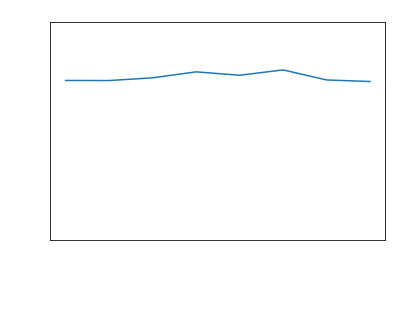

In [31]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    ax = pd.DataFrame.from_dict(clickthrough_by_day, orient = 'index').plot.line(legend = False)
    ax.set_ylim(0, 0.25)
    ax.set_xticklabels(labels = ['3/0{}/2016'.format(d) for d in range(1, 9)], rotation = 'vertical')
    ax.set_title('Clickthrough Rate By Day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Clickthrough Rate')

We can see that the clickthrough rate varies slighly by day, with the spread of clickthrough rates being roughly 1.3%, but remains fairly constant throughout the week. Next, we can compute the overall clickthrough rates by group:

In [32]:
clickthrough_by_group = {}

for group in ['a', 'b']:
    clicked = successful_searches.loc[data['group'] == group, :].shape[0]
    searched = total_searches.loc[data['group'] == group, :].shape[0]
    clickthrough_by_group[group] = clicked/searched
    
clickthrough_by_group

{'a': 0.20973103328408796, 'b': 0.13853049028928427}

Finally, we can compute and visualize the daily clickthrough rates of each group:

In [33]:
clickthrough_by_group_by_day = {}

for group in ['a', 'b']:
    clickthrough = []
    
    for date in list(data['date'].unique()):
        clicked = successful_searches.loc[(data['date'] == date) & (data['group'] == group), :].shape[0]
        searched = total_searches.loc[(data['date'] == date) & (data['group'] == group), :].shape[0]
        clickthrough.append(clicked/searched)
        
    clickthrough_by_group_by_day[group] = clickthrough
    
clickthrough_by_group_by_day

{'a': [0.21753298362740423,
  0.19670840223639657,
  0.21235521235521235,
  0.21543674698795182,
  0.20564328843474222,
  0.20051343174108371,
  0.21903052064631956,
  0.2101256859621172],
 'b': [0.10859806629834254,
  0.15779467680608364,
  0.11522922887756895,
  0.12025854737200205,
  0.15831881533101044,
  0.14452690166975882,
  0.1516624538207272,
  0.157336804909801]}

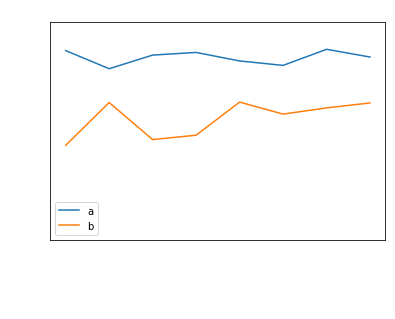

In [34]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    ax = pd.DataFrame.from_dict(clickthrough_by_group_by_day, orient = 'columns').plot.line()
    ax.set_ylim(0, 0.25)
    ax.set_xticklabels(labels = ['3/0{}/2016'.format(d) for d in range(9)], rotation = 'vertical')
    ax.set_title('Clickthrough Rate By Day, Per Group')
    ax.set_xlabel('Date')
    ax.set_ylabel('Clickthrough Rate')
    
    legend = ax.legend()
    plt.setp(legend.get_texts(), color = 'k')

We can see that in addition to the clickthrough rate for group A being much higher than the clickthrough rate for group B, the day-to-day variation of group B's clickthrough rate appears to be higher than that of group A.

**Which results do people tend to try first? How does it change day-to-day?**

The first results that people try during their searches is given by the value of first_click.

In [35]:
data['first_click'].describe()

count    25427.000000
mean         3.604043
std         38.967247
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       4087.000000
Name: first_click, dtype: float64

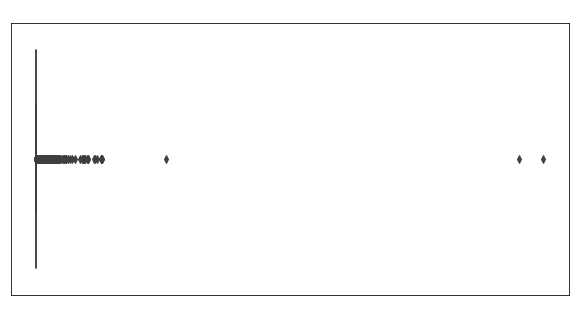

In [36]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax = sns.boxplot(x = data['first_click'])
    ax.set_title('Distribution of first_click')

Based on the summary statistics and the boxplot, we can see that the distribution of first_result is skewed extremely far to the right. At least half of all successful searches clicked on the first link first. We'll remove some outliers from the distribution:

In [37]:
p99 = data['first_click'].quantile(.99)
no_outliers = data.loc[data['first_click'] < p99, :]
p99

20.0

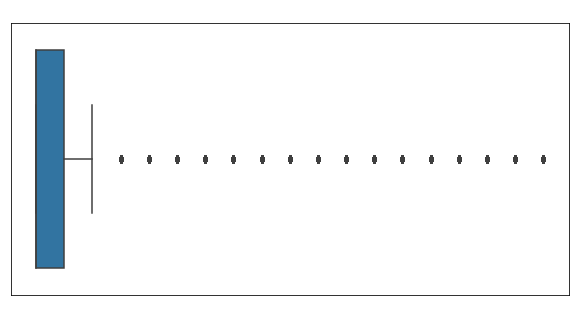

In [38]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(figsize = (10, 5))
    ax = sns.boxplot(x = no_outliers['first_click'])
    ax.set_title('Distribution of first_click (outliers removed)')

This truncated boxplot again illustrates how skewed the distribution of first_click is - even though its maxinmum value is over 4000, its 99th percentile value is only 20. Equivalently, 99% of users first clicked a link on the first page of search results.

We can visualize the distribution of first_click conditioned on the date and/or the group as well:

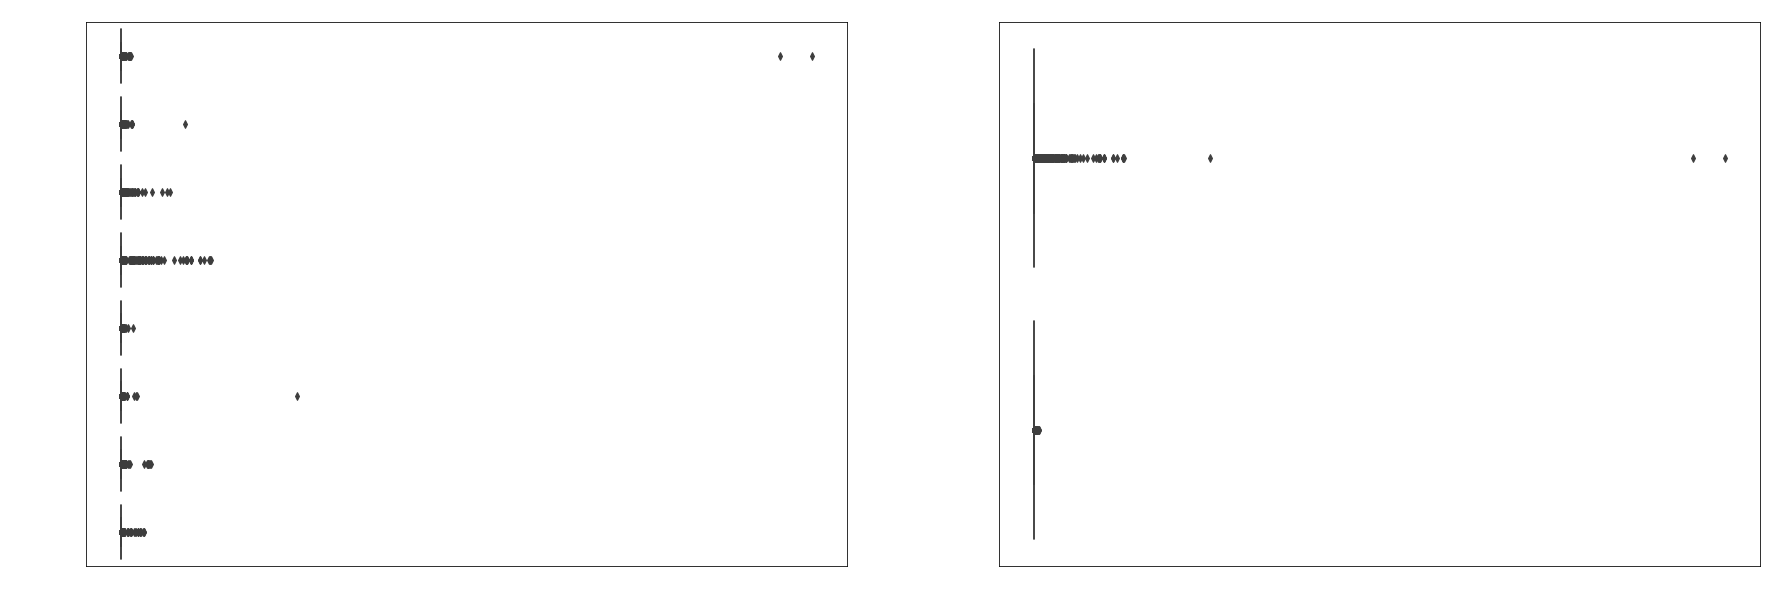

In [39]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(ncols = 2, figsize = (30, 10))
    sns.boxplot(x = data['first_click'], y = data['date'].sort_values().apply(str), ax = ax[0])
    ax[0].set_title('Distribution of first_click by date')
    sns.boxplot(x = data['first_click'], y = data['group'], order = ['a', 'b'], ax = ax[1])
    ax[1].set_title('Distribution of first_click by group')

Like in the overall cast, the outliers dominate the boxplots conditioned by day or group, except for the distribution of group B. We can compare the distributions between groups:

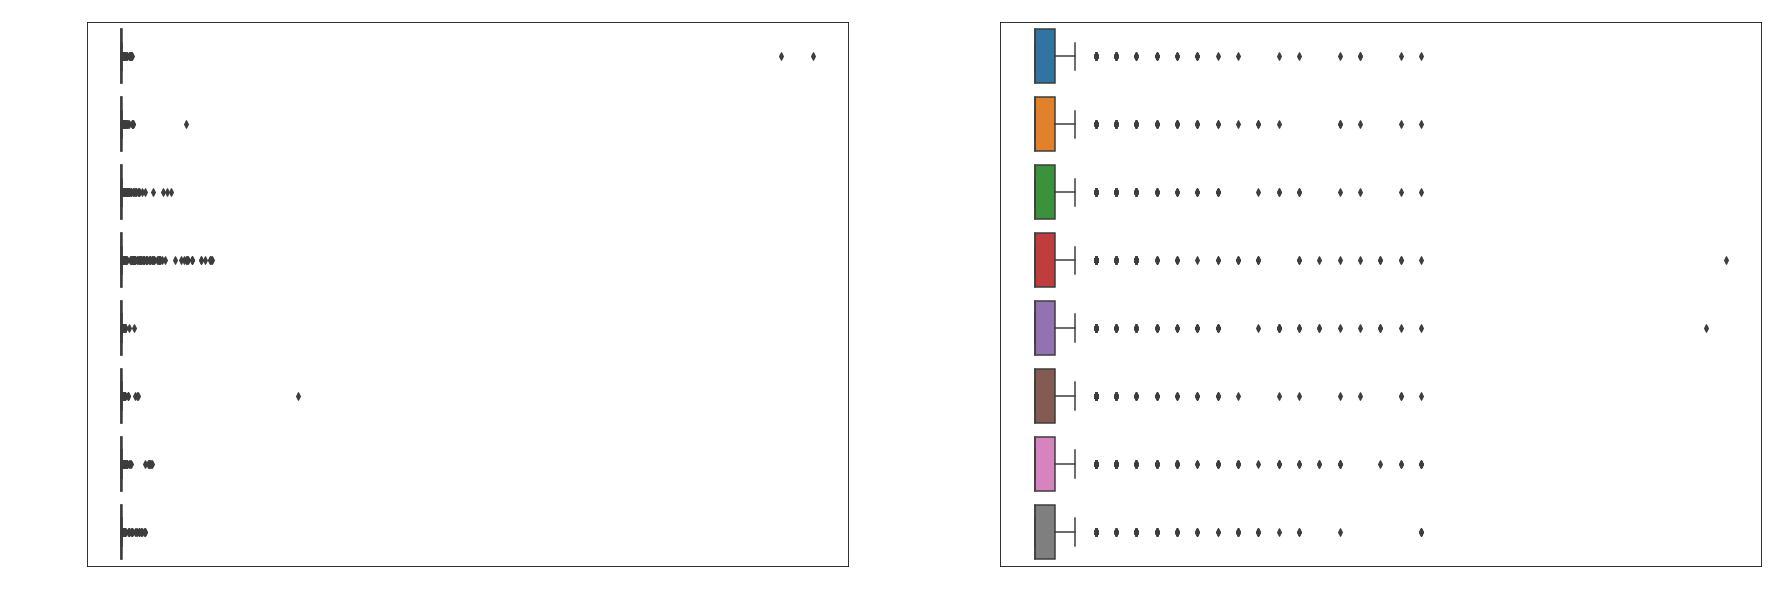

In [40]:
data['date_strings'] = data['date'].apply(str)
group_a = data.loc[data['group'] == 'a', :]
group_b = data.loc[data['group'] == 'b', :]
no_outliers = data.loc[data['first_click'] < p99, :]
date_order = ['2016-03-0{}'.format(d) for d in range(1, 9)]

with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(ncols = 2, figsize = (30, 10))
    sns.boxplot(x = 'first_click', y = 'date_strings', data = group_a, order = date_order, ax = ax[0])
    ax[0].set_title('Distribution of first_click in group A, by date')
    sns.boxplot(x = 'first_click', y = 'date_strings', data = group_b, order = date_order, ax = ax[1])
    ax[1].set_title('Distribution of first_click in group B, by date')

The distribution of first_click remains relatively unchanged when conditioning on date and group; every day, most users will click on the first search result first, and the vast majority of them will click on something on the first page. While this causes the distributions of both groups of users to skew extremely far to the right, the outliers in group A are much, much larger than the outliers of group B.

Finally, we can examine the distributions with the outliers removed:

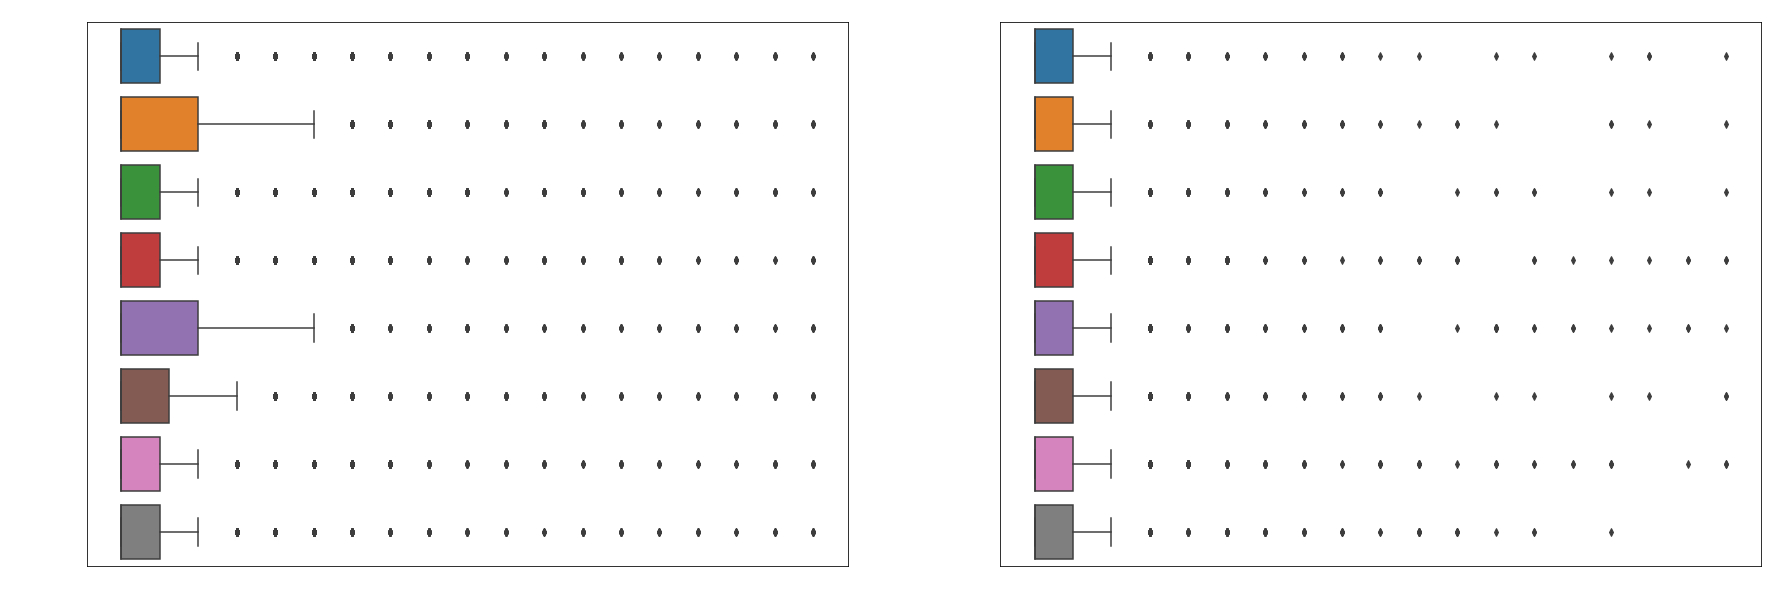

In [41]:
no_outliers_a = no_outliers.loc[data['group'] == 'a', :]
no_outliers_b = no_outliers.loc[data['group'] == 'b', :]

with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(ncols = 2, figsize = (30, 10))
    sns.boxplot(x = 'first_click', y = 'date_strings', data = no_outliers_a, order = date_order, ax = ax[0])
    ax[0].set_title('Distribution of first_click in group A, by date (outliers removed)')
    sns.boxplot(x = 'first_click', y = 'date_strings', data = no_outliers_b, order = date_order, ax = ax[1])
    ax[1].set_title('Distribution of first_click in group B, by date (outliers removed)')

With outliers removed, we can see that the bulk of the distributions are extremely similar. The most notable differences are that on some days, the distributions in group A are not as skewed right as they possibly could - suggesting that on those days, users in group A clicked on links slightly further down the page on average.

**What is our daily overall zero results rate? How does it vary between the groups?**

The zero results rate is given by the number of searchResultPage events where the value of n_results is 0, divided by the total number of searchResultPage events. First, as a sanity check, we should verify that every searchResultPage event has a numeric value for n_results - in particular, that no searchResultPage event has a null value for n_results.

In [42]:
zero_result_searches = data.loc[(data['action'] == 'searchResultPage') & (data['n_results'] == 0), :]
total_searches = data.loc[data['action'] == 'searchResultPage', :]

total_searches['n_results'].count() == total_searches.shape[0]

True

In [43]:
zero_result_searches.shape[0]/total_searches.shape[0]

0.18444000763392399

Computing the daily zero results rate is similar to computing the daily clickthrough rate:

In [44]:
zero_by_day = {}

for date in data['date'].unique():
    zero = zero_result_searches.loc[data['date'] == date, :].shape[0]
    searched = total_searches.loc[data['date'] == date, :].shape[0]
    zero_by_day[date] = zero/searched
    
zero_by_day

{datetime.date(2016, 3, 1): 0.18760204636987046,
 datetime.date(2016, 3, 2): 0.18987408739815892,
 datetime.date(2016, 3, 3): 0.17970666527480558,
 datetime.date(2016, 3, 4): 0.1808095952023988,
 datetime.date(2016, 3, 5): 0.1849439563768555,
 datetime.date(2016, 3, 6): 0.17615658362989323,
 datetime.date(2016, 3, 7): 0.18199989479774867,
 datetime.date(2016, 3, 8): 0.1937166349634902}

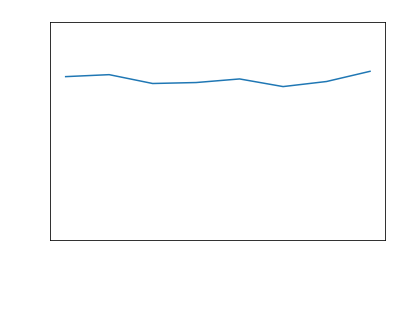

In [45]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    ax = pd.DataFrame.from_dict(zero_by_day, orient = 'index').plot.line(legend = False)
    ax.set_ylim(0, 0.25)
    ax.set_xticklabels(labels = ['3/0{}/2016'.format(d) for d in range(1, 9)], rotation = 'vertical')
    ax.set_title('Zero Results Rate By Day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Zero Results Rate')

We can see that the zero results rate varies slightly by day, with a spread of roughly 1.7% throughout the week. Next, we compute the zero results rate by group.

In [46]:
zero_by_group = {}

for group in ['a', 'b']:
    zero = zero_result_searches.loc[data['group'] == group, :].shape[0]
    searched = total_searches.loc[data['group'] == group, :].shape[0]
    zero_by_group[group] = zero/searched
    
zero_by_group

{'a': 0.1836056313548275, 'b': 0.1861786409525103}

Finally, we can compute and visualize the daily zero results rate for each group.

In [47]:
zero_by_group_day = {}

for group in ['a', 'b']:
    zero_by_date = []
    
    for date in data['date'].unique():
        zero = zero_result_searches.loc[(data['group'] == group) & (data['date'] == date), :].shape[0]
        searched = total_searches.loc[(data['group'] == group) & (data['date'] == date), :].shape[0]
        zero_by_date.append(zero/searched)
        
    zero_by_group_day[group] = zero_by_date
    
zero_by_group_day

{'a': [0.18677475759020823,
  0.18237656508386488,
  0.19108183814066168,
  0.17853915662650602,
  0.17823966558290757,
  0.1961125882460805,
  0.16886682859858484,
  0.18304124623827225],
 'b': [0.18939917127071823,
  0.18124207858048164,
  0.18707184261373616,
  0.18234393604354482,
  0.19751742160278746,
  0.1888682745825603,
  0.189578067275909,
  0.1761205132973777]}

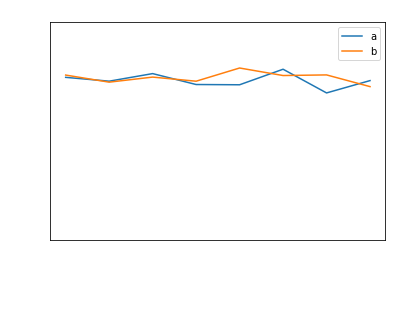

In [48]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    ax = pd.DataFrame.from_dict(zero_by_group_day, orient = 'columns').plot.line()
    ax.set_ylim(0, 0.25)
    ax.set_xticklabels(labels = ['3/0{}/2016'.format(d) for d in range(9)], rotation = 'vertical')
    ax.set_title('Zero Result Rate By Day, Per Group')
    ax.set_xlabel('Date')
    ax.set_ylabel('Zero Result Rate')
    
    legend = ax.legend()
    plt.setp(legend.get_texts(), color = 'k')

We can see that the zero result rates of each group are roughly the same, although it appears that the daily zero results rate for group A experiences slightly more variation than that of group B.

**Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.**

First, we need to compute the session lengths for each session. We can find the timestamps for the first and last event of each session by created pivot tables and aggregating over the minimum and maximum timestamps for each session.

In [49]:
sessions = data.loc[:, ["session_id", "timestamp"]]
sessions.head()

session_id           timestamp
0  78245c2c3fba013a 2016-03-01 10:38:42
1  c559c3be98dca8a4 2016-03-07 00:52:26
2  760bf89817ce4b08 2016-03-02 14:53:05
3  fb905603d31b2071 2016-03-02 22:27:01
4  c2bf5e5172a892dc 2016-03-02 09:50:23

In [50]:
max_times = pd.pivot_table(sessions, 'timestamp', 'session_id', aggfunc = max)
max_times.head()

timestamp
session_id                          
0000cbcb67c19c45 2016-03-03 15:20:45
0001382e027b2ea4 2016-03-07 08:54:58
0001e8bb90445cb2 2016-03-05 09:31:30
000216cf18ae1ab1 2016-03-08 16:20:44
000527f711d50dfc 2016-03-08 05:33:00

In [51]:
min_times = pd.pivot_table(sessions, 'timestamp', 'session_id', aggfunc = min)
min_times.head()

timestamp
session_id                          
0000cbcb67c19c45 2016-03-03 15:20:45
0001382e027b2ea4 2016-03-07 08:49:55
0001e8bb90445cb2 2016-03-05 09:24:15
000216cf18ae1ab1 2016-03-08 16:19:46
000527f711d50dfc 2016-03-08 05:33:00

The session length of each session will be the difference between the maximum and minimum timestamps.

In [52]:
session_lengths = max_times['timestamp'] - min_times['timestamp']
session_lengths.head()

session_id
0000cbcb67c19c45   00:00:00
0001382e027b2ea4   00:05:03
0001e8bb90445cb2   00:07:15
000216cf18ae1ab1   00:00:58
000527f711d50dfc   00:00:00
Name: timestamp, dtype: timedelta64[ns]

In [53]:
session_lengths.describe()

count                     68028
mean     0 days 00:02:33.531810
std      0 days 00:36:37.971389
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 00:00:15
75%             0 days 00:02:18
max             5 days 20:14:39
Name: timestamp, dtype: object

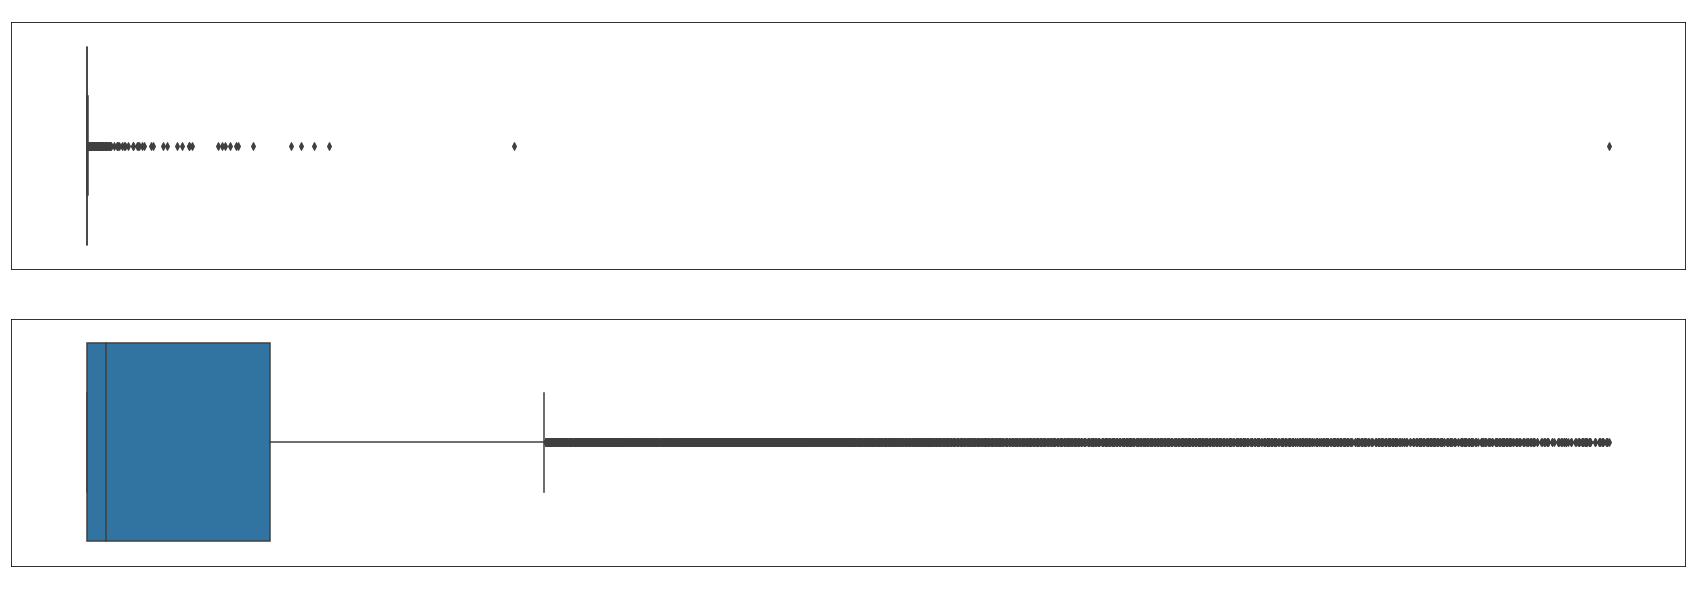

In [54]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(nrows = 2, figsize = (30, 10))
    sns.boxplot(x = session_lengths, ax = ax[0])
    ax[0].set_title('Distribution of session_lengths')
    sns.boxplot(x = session_lengths[session_lengths < session_lengths.quantile(.99)], ax = ax[1])
    ax[1].set_title('Distribution of session_lengths (outliers removed)')

The distribution of session_lengths is skewed extremely far to the right. The majority of sessions last less than a minute, and a large percentage of the sessions last 0 seconds:

In [55]:
zero_seconds = session_lengths[session_lengths == session_lengths.quantile(.25)].shape[0]
zero_seconds/session_lengths.shape[0]

0.4058034926794849

Before we examine the relationship between session length and a particular variable, we'll add some possible choices to our pivot table and examine the pairwise correlations between these choices and session length. A correlation wouldn't be a sure sign of a relationship, since it can only provide a metric for how well the variables fit a linear relationship, and it obviously doesn't suggest a causal relationship between them. But it gives us a place to start.

To find possible candidates for variables, we'll take columns from our data and transform them by aggregating them over each session. Here are the variables we'll use:

* first_click: aggregating this using count gives us the number of non-null values of first_click in a session, or equivalently, the number of successful searches; aggregating using mean will give us the average position of the first result clicked per session.
* n_results: aggreating this using count gives us the number of total searches in a session; aggregating using mean will give us the average number of search results per session.
* timestamp: in general it might be insightful to examine the relationship between the length of the session and when it occured. Aggregating by the min and max timestamps will give us the start and end times of each session, respectively.
* checkin: aggregating by the max checkin value will give us the longest that a session was checked into a particular page. The number of checkin events per session would be a somewhat deceptive statistic since checkin times don't occur at a constant frequency over time.

In [56]:
numeric_cols = pd.pivot_table(data = data, values = ['first_click', 'n_results', 'timestamp', 'checkin'], 
                              index = 'session_id',
                              aggfunc = {'first_click' : ['count', np.mean],
                                         'n_results' : ['count', np.mean],
                                         'timestamp' : [min, max],
                                         'checkin' : max})

In [57]:
numeric_cols.head()

checkin first_click      n_results                 timestamp  \
                     max       count mean     count  mean                 max   
session_id                                                                      
0000cbcb67c19c45     NaN           0  NaN         1  20.0 2016-03-03 15:20:45   
0001382e027b2ea4   300.0           1  1.0         1  18.0 2016-03-07 08:54:58   
0001e8bb90445cb2   420.0           1  1.0         1  20.0 2016-03-05 09:31:30   
000216cf18ae1ab1     NaN           0  NaN         6  20.0 2016-03-08 16:20:44   
000527f711d50dfc     NaN           0  NaN         1   1.0 2016-03-08 05:33:00   

                                      
                                 min  
session_id                            
0000cbcb67c19c45 2016-03-03 15:20:45  
0001382e027b2ea4 2016-03-07 08:49:55  
0001e8bb90445cb2 2016-03-05 09:24:15  
000216cf18ae1ab1 2016-03-08 16:19:46  
000527f711d50dfc 2016-03-08 05:33:00

In [58]:
numeric_cols.columns

MultiIndex(levels=[['checkin', 'first_click', 'n_results', 'timestamp'], ['count', 'max', 'mean', 'min']],
           labels=[[0, 1, 1, 2, 2, 3, 3], [1, 0, 2, 0, 2, 1, 3]])

In [59]:
numeric_cols['session_length', ''] = session_lengths.apply(lambda x: x.total_seconds())

In [60]:
numeric_cols.head()

checkin first_click      n_results                 timestamp  \
                     max       count mean     count  mean                 max   
session_id                                                                      
0000cbcb67c19c45     NaN           0  NaN         1  20.0 2016-03-03 15:20:45   
0001382e027b2ea4   300.0           1  1.0         1  18.0 2016-03-07 08:54:58   
0001e8bb90445cb2   420.0           1  1.0         1  20.0 2016-03-05 09:31:30   
000216cf18ae1ab1     NaN           0  NaN         6  20.0 2016-03-08 16:20:44   
000527f711d50dfc     NaN           0  NaN         1   1.0 2016-03-08 05:33:00   

                                     session_length  
                                 min                 
session_id                                           
0000cbcb67c19c45 2016-03-03 15:20:45            0.0  
0001382e027b2ea4 2016-03-07 08:49:55          303.0  
0001e8bb90445cb2 2016-03-05 09:24:15          435.0  
000216cf18ae1ab1 2016-03-08 16:19:46           58.0  
000527f711d50dfc 2016-03-08 05:33:00            0.0

In [61]:
numeric_cols.describe()

checkin   first_click                   n_results                \
                max         count          mean         count          mean   
count  23295.000000  68028.000000  20949.000000  68028.000000  67951.000000   
mean     176.995922      0.373773      2.486592      2.002617     13.582082   
std      164.121931      0.798693     28.033863      3.442237      9.176742   
min       10.000000      0.000000      1.000000      0.000000      0.000000   
25%       30.000000      0.000000      1.000000      1.000000      5.000000   
50%       90.000000      0.000000      1.000000      1.000000     20.000000   
75%      420.000000      1.000000      2.000000      2.000000     20.000000   
max      420.000000     56.000000   3991.000000    484.000000    500.000000   

      session_length  
                      
count    68028.00000  
mean       153.53181  
std       2197.97139  
min          0.00000  
25%          0.00000  
50%         15.00000  
75%        138.00000  
max     504879.00000

In addition to these numeric variables, we can also compare session length between different groups. To add this information to the pivot table, we'll first need to encode the groups as numbers - we'll map A to 0 and B to 1.

In [62]:
data['group'].replace(to_replace = {'a' : 0, 'b': 1}, inplace = True)

In [63]:
print('Group A: %d \nGroup B: %d' % 
      (len(data.loc[data['group'] == 0]), len(data.loc[data['group'] == 1])))

Group A: 299019 
Group B: 101146


In [64]:
numeric_cols['group', ''] = pd.pivot_table(data = data, values = 'group', index = 'session_id', aggfunc = np.median)

In [65]:
numeric_cols['group', ''].replace(to_replace = {0 : 'a', 1 : 'b'}, inplace = True)

In [66]:
numeric_cols.corr()

checkin first_click           n_results            \
                           max       count      mean     count      mean   
checkin        max    1.000000    0.013077 -0.007532 -0.052150  0.014522   
first_click    count  0.013077    1.000000  0.047173  0.261464  0.164144   
               mean  -0.007532    0.047173  1.000000  0.072119  0.052385   
n_results      count -0.052150    0.261464  0.072119  1.000000 -0.023600   
               mean   0.014522    0.164144  0.052385 -0.023600  1.000000   
session_length        0.066292    0.089096  0.002741  0.077442  0.016041   

                     session_length  
                                     
checkin        max         0.066292  
first_click    count       0.089096  
               mean        0.002741  
n_results      count       0.077442  
               mean        0.016041  
session_length             1.000000

None of the numeric variables are strongly correlated to session length. The three variables that stand out are first_click count (which corresponds to the number of successful searches in a session), n_results count (which corresponds to the total number of searches in a session), and checkin max (which corresponds to the longest amount of time a session was checked into a page).

Let's examine the relationship between session length and the number of successful searches.

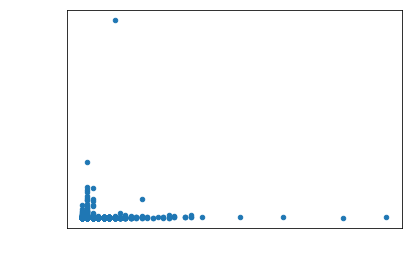

In [67]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    numeric_cols.plot.scatter(x = ('first_click', 'count'), y = 'session_length')

This scatterplot obscures any possible patterns in the data due to the presence of outliers. We can remove them from the scatterplot:

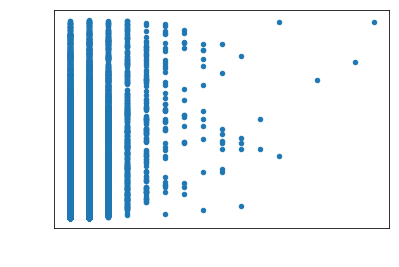

In [68]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    numeric_cols.loc[numeric_cols['session_length'] < numeric_cols['session_length'].quantile(.99), :].plot.scatter(x = ('first_click', 'count'), y = 'session_length')

The scatterplot loosely illustrates a relationship between the variables - the distribution of session lengths trends slightly upward as the number of successful searches in the session increases. But the density of points on most of this scatterplot suggests that we should care about the number of sessions in each combination of session length and successful searches. To visualize this, we'll use a heatmap.

Before we can create the heatmap, we'll first need to create another pivot table from our existing pivot table, using session lengths as the indices and aggregating on number of successful searches. Since session_lengths is measured in seconds, using that column as is for the index would result in a pivot table with thousands of rows, compared to the few dozen possible numbers of successful searches. We don't really need to distinguish between a 10 second session and a 20 second session, so we'll first create a new column of pivot that contains the session length in minutes, rounded to the nearest minute. We'll use this column as the index of our new pivot table.

In [69]:
numeric_cols['minute_length'] = numeric_cols['session_length'].apply(lambda x: round(x / 60))

In [70]:
new_pivot = pd.DataFrame(data = numeric_cols['minute_length'], index = numeric_cols.index)
new_pivot['successes'] = numeric_cols['first_click', 'count']

In [71]:
heatmap_pivot = new_pivot.pivot_table(index = 'minute_length', columns = 'successes', aggfunc = len)
heatmap_pivot

successes           0       1      2     3     4    5    6    7    8    9   \
minute_length                                                                
0              34828.0  3824.0   64.0   2.0   NaN  1.0  NaN  NaN  NaN  NaN   
1               4639.0  3983.0  200.0  18.0   NaN  NaN  NaN  1.0  NaN  1.0   
2               1814.0  1946.0  185.0  30.0  13.0  1.0  1.0  NaN  NaN  NaN   
3               1044.0  1163.0  139.0  26.0   9.0  4.0  2.0  NaN  NaN  NaN   
4                812.0  1020.0  126.0  24.0   6.0  1.0  NaN  1.0  2.0  NaN   
5                518.0   664.0  123.0  25.0   6.0  1.0  NaN  NaN  NaN  NaN   
6                463.0   532.0  116.0  25.0   8.0  3.0  NaN  NaN  1.0  1.0   
7                958.0  3128.0  128.0  28.0   6.0  1.0  3.0  1.0  2.0  2.0   
8                661.0   844.0  125.0  28.0  12.0  3.0  1.0  1.0  2.0  NaN   
9                382.0   306.0  109.0  18.0  11.0  4.0  3.0  1.0  NaN  NaN   
10               251.0   209.0   99.0  31.0   7.0  6.0  NaN  1.0  NaN  NaN   
11               146.0   142.0   65.0  16.0   4.0  2.0  1.0  NaN  NaN  NaN   
12                90.0   118.0   47.0   8.0   5.0  2.0  1.0  1.0  NaN  NaN   
13                71.0   102.0   53.0  15.0   8.0  1.0  NaN  NaN  1.0  NaN   
14                60.0    80.0   22.0  14.0   6.0  4.0  NaN  2.0  NaN  NaN   
15                60.0    51.0   27.0   8.0   7.0  2.0  NaN  2.0  NaN  1.0   
16                44.0    45.0   33.0  12.0   6.0  1.0  3.0  1.0  1.0  NaN   
17                42.0    35.0   17.0  12.0   2.0  4.0  2.0  NaN  NaN  NaN   
18                27.0    31.0   16.0  13.0   5.0  1.0  1.0  NaN  NaN  1.0   
19                26.0    26.0    8.0   8.0   5.0  1.0  2.0  NaN  NaN  NaN   
20                16.0    14.0    5.0  10.0   3.0  1.0  NaN  NaN  NaN  NaN   
21                11.0    12.0   10.0   9.0   6.0  NaN  1.0  1.0  NaN  NaN   
22                10.0    12.0    5.0   4.0   3.0  3.0  3.0  2.0  NaN  NaN   
23                 9.0    10.0    7.0   6.0   1.0  1.0  NaN  NaN  1.0  NaN   
24                 8.0    10.0    6.0   7.0   4.0  1.0  NaN  NaN  1.0  1.0   
25                 7.0     5.0    4.0   5.0   1.0  NaN  NaN  NaN  1.0  NaN   
26                 2.0     4.0    4.0   1.0   NaN  1.0  NaN  NaN  1.0  NaN   
27                 6.0     6.0    3.0   1.0   2.0  2.0  NaN  NaN  NaN  NaN   
28                 5.0     3.0    3.0   2.0   4.0  1.0  NaN  NaN  NaN  NaN   
29                 6.0     9.0    3.0   2.0   NaN  1.0  NaN  1.0  NaN  NaN   
...                ...     ...    ...   ...   ...  ...  ...  ...  ...  ...   
228                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
253                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
255                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
277                1.0     NaN    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
283                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
289                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
307                1.0     NaN    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
317                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
354                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
367                1.0     NaN    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
423                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
442                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
497                NaN     NaN    1.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
526                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
562                NaN     NaN    1.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
565                1.0     NaN    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
579                NaN     1.0    NaN   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
727                NaN     NaN    1.0   NaN   NaN  NaN  NaN  NaN  NaN  NaN   
749                NaN

Recalling that the distribution of session lengths was skewed heavily to the right, it's reasonable to remove some of the more egregious outliers from the pivot table:

In [72]:
heatmap_no_outliers = new_pivot.loc[new_pivot['minute_length'] < new_pivot['minute_length'].quantile(.99), :].pivot_table(index = 'minute_length', columns = 'successes', aggfunc = len)

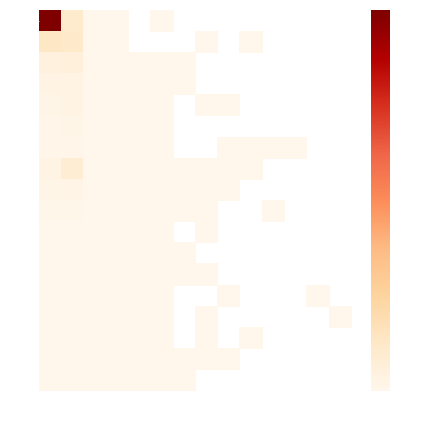

In [73]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(data = heatmap_no_outliers, cmap = 'OrRd', ax = ax)

The point at (0, 0) on the heatmap makes it difficult to see patterns in the rest of the data. Frankly, that's what we're more interested in at the moment - we already know that most sessions are less than a minute long, and most searches aren't successful, so that (0, 0) is the most densely populated point on this heatmap is no surprise. We'll create a heatmap without the zero-length searches:

In [74]:
heatmap_no_zeros = new_pivot.loc[(new_pivot['minute_length'] > 0) & (new_pivot['minute_length'] < new_pivot['minute_length'].quantile(.99)), :].pivot_table(index = 'minute_length', columns = 'successes', aggfunc = len)

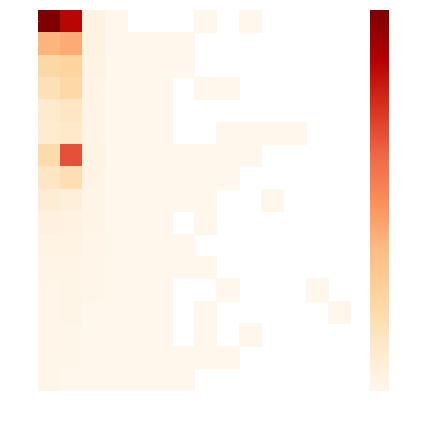

In [75]:
with plt.rc_context({'xtick.color' : 'white', 'ytick.color' : 'white', 'axes.labelcolor' : 'white', 'text.color' : 'white'}):
    fig, ax = plt.subplots(figsize = (7, 7))
    sns.heatmap(data = heatmap_no_zeros, cmap = 'OrRd', ax = ax)
    ax.set_ylabel('Session Length (in Minutes)')
    ax.set_xlabel('Number of Successful Searches in Session')
    ax.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '15'], rotation = 'horizontal')

One observation we can make here that wasn't very obvious from the previous heatmap is the concentration of sessions that lasted for 7 minutes with 1 successful search - there are many more results here than in surrounding bins, comparable to the bins on the top left corner corresponding to 1 minute sessions returning 0 or 1 successful searches.